<a href="https://colab.research.google.com/github/r-o-h-a-n-2004/mask-rcnn-/blob/main/mak_rcnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Using device: cuda


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth
100%|██████████| 170M/170M [00:01<00:00, 121MB/s]


Epoch 1/10, Loss: 0.4798
Epoch 2/10, Loss: 0.2386
Epoch 3/10, Loss: 0.1943
Epoch 4/10, Loss: 0.1746
Epoch 5/10, Loss: 0.1577
Epoch 6/10, Loss: 0.1435
Epoch 7/10, Loss: 0.1371
Epoch 8/10, Loss: 0.1346
Epoch 9/10, Loss: 0.1334
Epoch 10/10, Loss: 0.1328
Model saved.


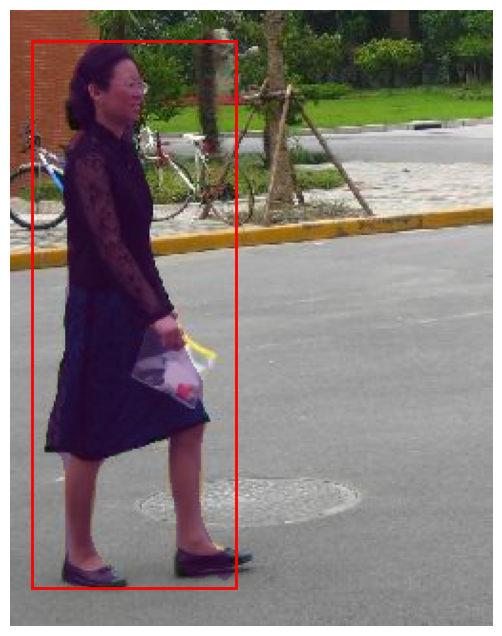

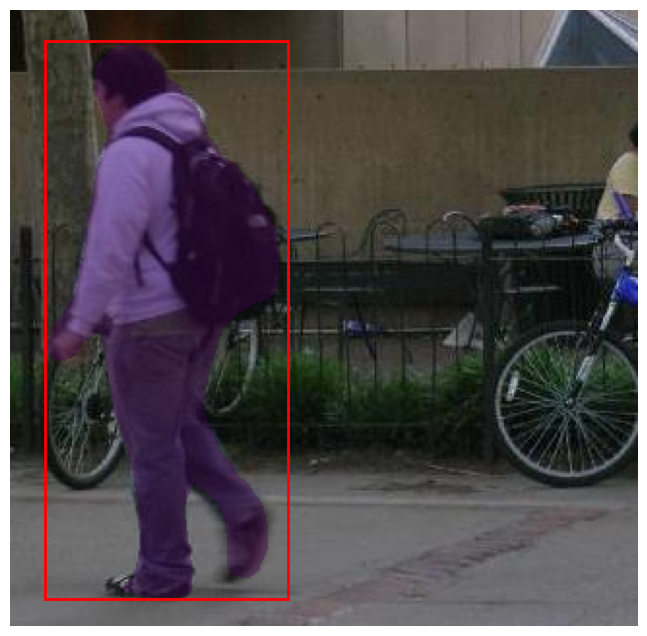

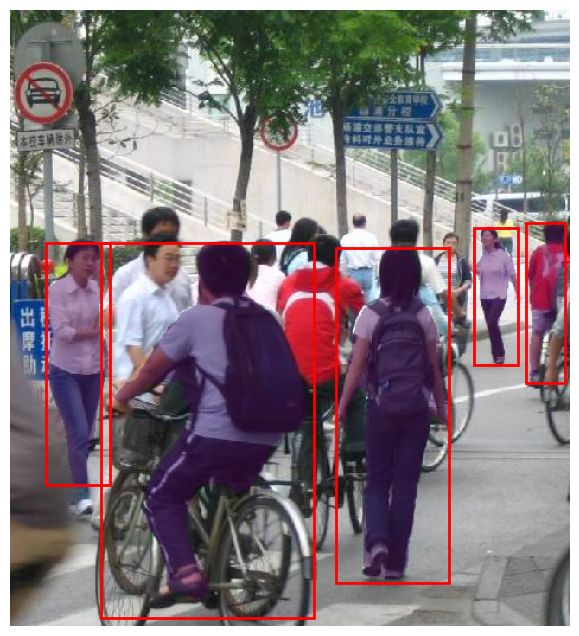

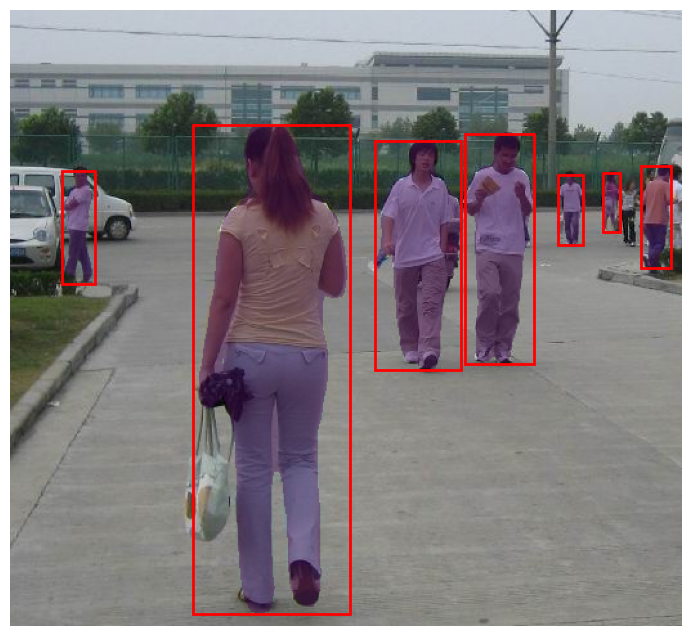

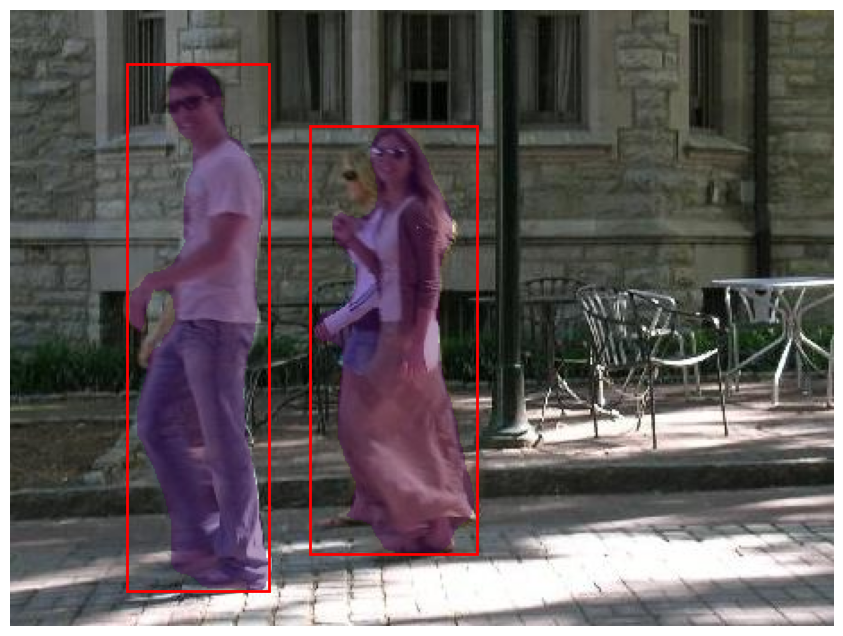

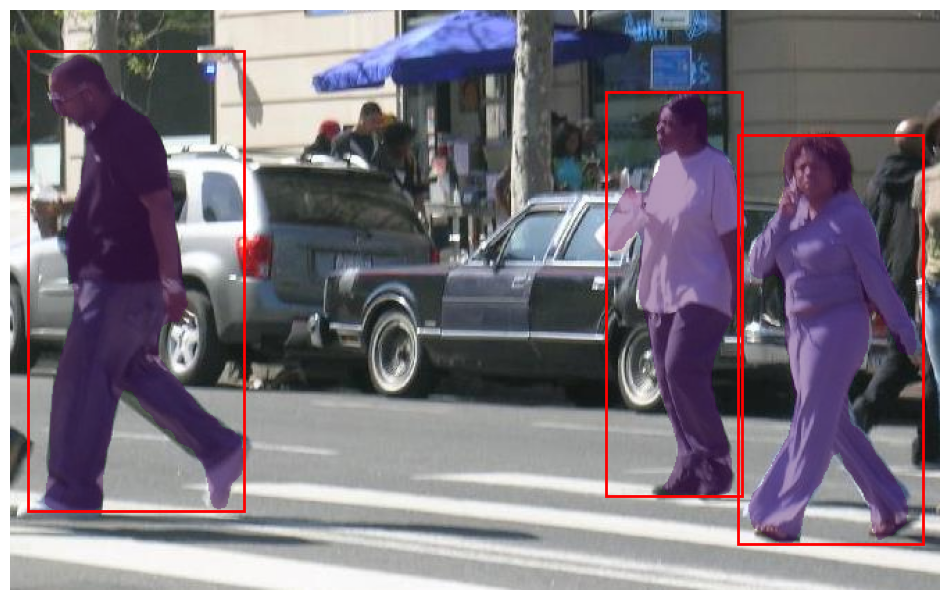

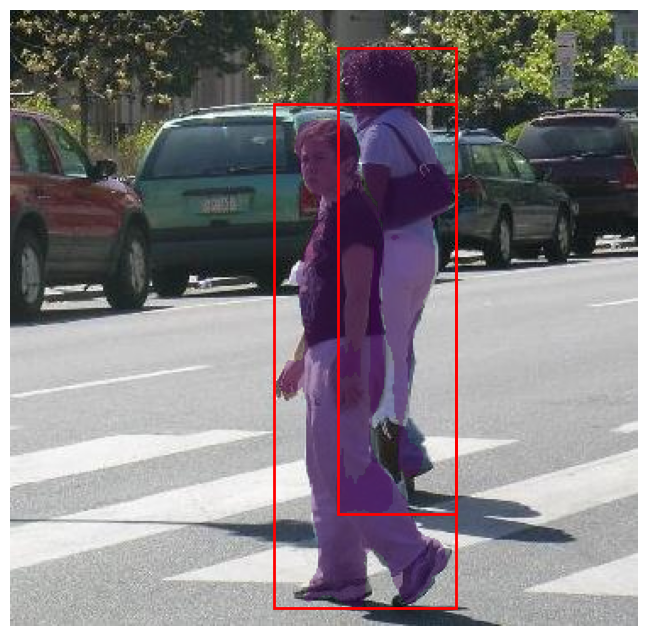

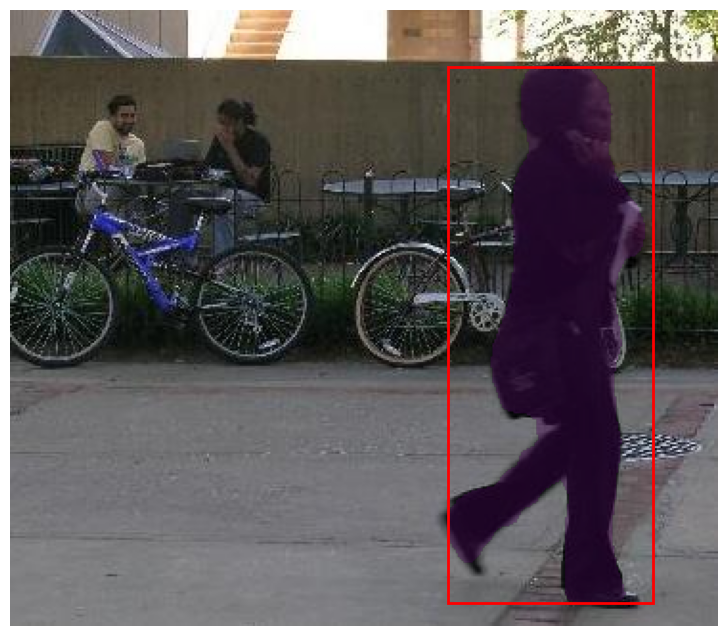

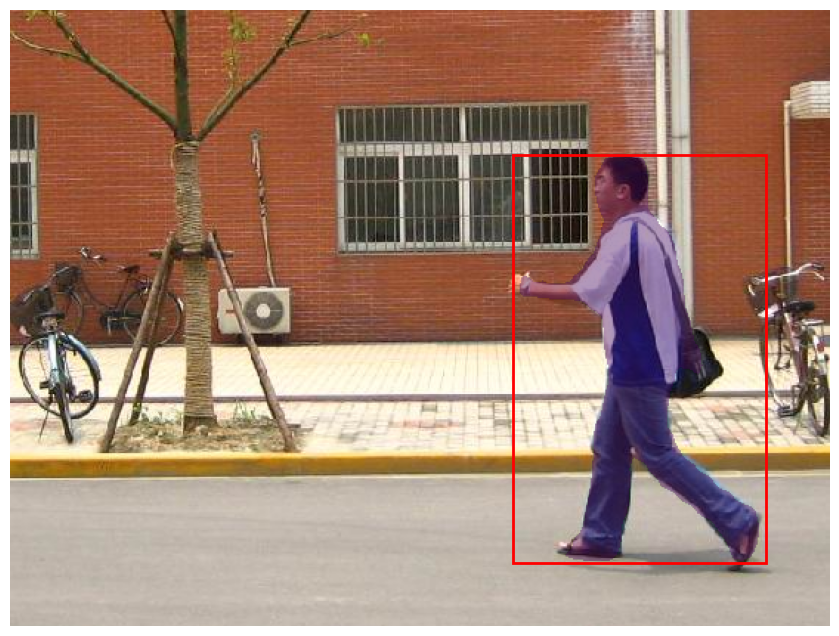

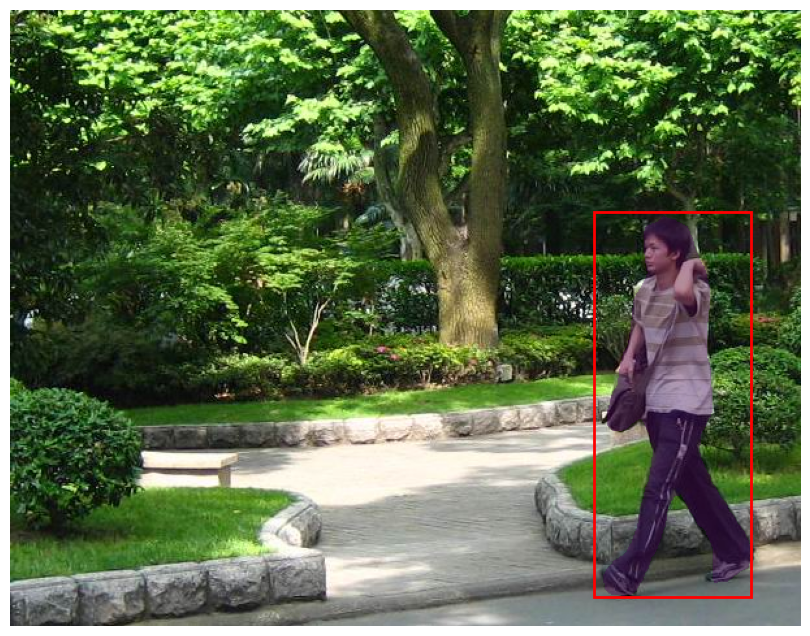

In [1]:
import torch
import torchvision
from torchvision.models.detection import MaskRCNN
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torch.utils.data import Dataset, DataLoader
import numpy as np
from PIL import Image
import os
import random
import time
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Device config
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Download PennFudanPed dataset
!wget -q https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip
!unzip -q -o PennFudanPed.zip
!rm PennFudanPed.zip

# Dataset class
class PennFudanDataset(Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        self.imgs = sorted(os.listdir(os.path.join(root, "PNGImages")))
        self.masks = sorted(os.listdir(os.path.join(root, "PedMasks")))

    def __getitem__(self, idx):
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])

        img = Image.open(img_path).convert("RGB")
        mask = np.array(Image.open(mask_path))

        obj_ids = np.unique(mask)[1:]
        masks = mask == obj_ids[:, None, None]

        boxes = []
        for m in masks:
            pos = np.where(m)
            xmin, xmax = np.min(pos[1]), np.max(pos[1])
            ymin, ymax = np.min(pos[0]), np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.ones((len(boxes),), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)
        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((len(boxes),), dtype=torch.int64)

        target = {"boxes": boxes, "labels": labels, "masks": masks,
                  "image_id": image_id, "area": area, "iscrowd": iscrowd}

        if self.transforms:
            img = self.transforms(img)

        return img, target

    def __len__(self):
        return len(self.imgs)

# Transform
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
])

# Prepare datasets
dataset = PennFudanDataset("PennFudanPed", transforms=transform)
torch.manual_seed(42)
indices = torch.randperm(len(dataset)).tolist()
train_dataset = torch.utils.data.Subset(dataset, indices[:-10])
test_dataset = torch.utils.data.Subset(dataset, indices[-10:])

def collate_fn(batch):
    return tuple(zip(*batch))

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, collate_fn=collate_fn)

# Create Mask R-CNN model
def get_model(num_classes):
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, hidden_layer, num_classes)

    return model

# Model init
model = get_model(num_classes=2)
model.to(device)

# Optimizer and scheduler
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

# Training
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for images, targets in train_loader:
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        epoch_loss += losses.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss / len(train_loader):.4f}")
    lr_scheduler.step()

# Save model
torch.save(model.state_dict(), "maskrcnn_pennfudan.pth")
print("Model saved.")

# Visualization
def visualize(image, boxes, masks=None, scores=None, threshold=0.5):
    img = image.permute(1, 2, 0).cpu().numpy()
    fig, ax = plt.subplots(1, figsize=(12, 8))
    ax.imshow(img)

    for i, box in enumerate(boxes):
        if scores is not None and scores[i] < threshold:
            continue
        xmin, ymin, xmax, ymax = box
        rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                 linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        if masks is not None:
            mask = masks[i, 0].cpu().numpy() > 0.5
            ax.imshow(np.ma.masked_where(~mask, mask), alpha=0.4)

    plt.axis('off')
    plt.show()

# Testing
model.eval()
with torch.no_grad():
    for images, _ in test_loader:
        images = [img.to(device) for img in images]
        outputs = model(images)
        for i in range(len(images)):
            boxes = outputs[i]['boxes'].cpu()
            masks = outputs[i]['masks'].cpu()
            scores = outputs[i]['scores'].cpu()
            visualize(images[i].cpu(), boxes, masks, scores, threshold=0.5)
